<a href="https://colab.research.google.com/github/vahadruya/Capstone-Project-Unsupervised-ML-Topic-Modelling/blob/main/Intermediate_Colab_Notebooks/Rough2_3_code_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_colwidth', None)

## 1. Reading the Data

In [ ]:
def organise_data(df):
  df['Description'] = ''
  for row in df[df.columns.values[0]]:
    df['Description'] += ' ' + row
  df['Title'] = df.columns.values[0]
  df = pd.DataFrame(df[['Title', 'Description']].loc[0]).transpose()
  return df

def read_from_folder(category, path):
  files = glob.glob(path + category + "/*.txt")
  df = pd.DataFrame(pd.read_table(files[0]))
  df = organise_data(df)
  for i in range(1, len(files)):
    try:
      next_df = pd.DataFrame(pd.read_table(files[i]))
    except UnicodeDecodeError:
      next_df = pd.DataFrame(pd.read_table(files[i], encoding = 'ISO-8859-1'))
      # https://stackoverflow.com/questions/64188953/python-parsererror-error-tokenizing-data-c-error-eof-inside-string-starting
    except pd.errors.ParserError:
      next_df = pd.DataFrame(pd.read_table(files[i], quoting=csv.QUOTE_NONE))
      # https://stackoverflow.com/questions/51536708/python-catch-exception-pandas-errors-parsererror-error-tokenizing-data-c-erro
    next_df = organise_data(next_df)
    df = pd.concat([df, next_df], axis=0)
    df['Category'] = category.capitalize()
    df = df.reset_index(drop=True)
  return df
  # https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/

def read_from_folders(categories, path):
  category_dict = dict()
  for category in categories:
    category_dict[category] = read_from_folder(category, path)
  final_data = pd.concat([category_dict[category] for category in categories], axis=0).reset_index(drop=True)
  return final_data

In [ ]:
path = '/content/drive/MyDrive/ALMA BETTER/Module 4/#CAPSTONE 3 - UNSUPERVISED/Data/'
folders = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
files = glob.glob(path + 'business' + "/*.txt")
df = pd.DataFrame(pd.read_table(files[0]))


In [ ]:
df

,India calls for fair trade rules
0,"India, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlikely to be cowed by its newcomer status."
1,"In London on Thursday ahead of the meeting, India's finance minister, lashed out at the restrictive trade policies of the G7 nations. He objected to subsidies on agriculture that make it hard for developing nations like India to compete. He also called for reform of the United Nations, the World Bank and the IMF."
2,"Palaniappan Chidambaram, India's finance minister, argued that these organisations need to take into account the changing world order, given India and China's integration into the global economy. He said the issue is not globalisation but ""the terms of engagement in globalisation."" Mr Chidambaram is attending the G7 meeting as part of the G20 group of nations, which account for two thirds of the world's population. At a conference on developing enterprise hosted by UK finance minister Gordon Brown on Friday, he said that he was in favour of floating exchange rates because they help countries cope with economic shocks. ""A flexible exchange rate is one more channel for absorbing both positive and negative shocks,"" he told the conference. India, along with China, Brazil, South Africa and Russia, has been invited to take part in the G7 meeting taking place in London on Friday and Saturday. China is expected to face renewed pressure to abandon its fixed exchange rate, which G7 nations, in particular the US, have blamed for a surge in cheap Chinese exports. ""Some countries have tried to use fixed exchange rates. I do not wish to make any judgements,"" Mr Chidambaram said. Separately, the IMF warned on Thursday that India's budget deficit was too large and would hamper the country's economic growth, which it forecast to be around 6.5% in the year to March 2005. In the year to March 2004, the Indian economy grew by 8.5%."


In [ ]:
df.columns.values

array(['India calls for fair trade rules'], dtype=object)

In [ ]:
data = read_from_folders(folders, path)

In [ ]:
data.isna().sum()

Title          0
Description    0
Category       0
dtype: int64

In [ ]:
data.drop_duplicates(inplace=True, ignore_index = True)
# https://stackoverflow.com/questions/28885073/reindexing-after-pandas-drop-duplicates

In [ ]:
data.shape

(2125, 3)

In [ ]:
data['Category'].value_counts()

Business         503
Sport            503
Politics         403
Entertainment    369
Tech             347
Name: Category, dtype: int64

<AxesSubplot:>

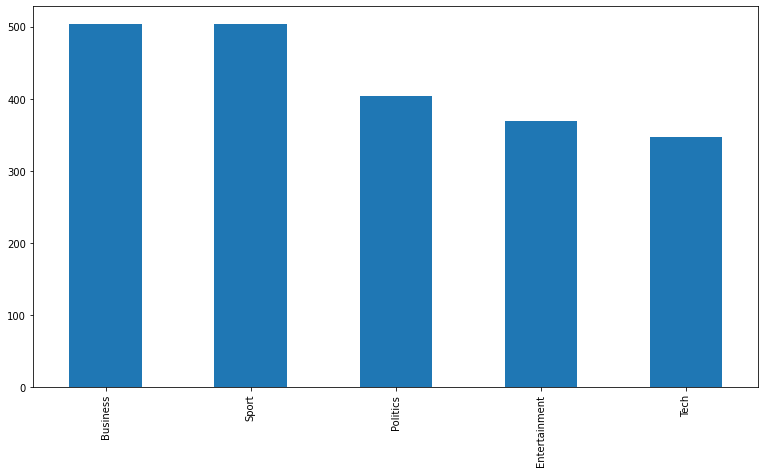

In [ ]:
data['Category'].value_counts().plot(kind='bar', figsize = (13,7))

## 2. Data Pre-Processing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2.1 Removing Stopwords and Punctuations

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import contractions
def contractio(text):
  expanded_words = []
  for word in text.split():
  # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

# https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675

In [ ]:
# data['Description'] = data['Description'].apply(contractio)

In [ ]:
def lowerise(text):
  return text.lower()

In [ ]:
data['Description'] = data['Description'].apply(lowerise)

In [ ]:
# def remove_punc(text):
#   return text.translate(text.maketrans('', '', string.punctuation))
def remove_punc(text):
  return re.sub(r'\W',' ',text)

def remove_stopwords(text, stop_words):
  # https://stackoverflow.com/questions/11205254/why-do-these-list-operations-methods-clear-extend-reverse-append-sort
  text = [word for word in text.split() if word.lower() not in stop_words]
  return ' '.join(text)

def remove_ws(text):
  return re.sub(r'\s+',' ',text)

def remove_digi(text):
  return re.sub(r'\d',' ',text)

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
data['Description'] = data['Description'].apply(remove_punc)
data['Description'] = data['Description'].apply(remove_digi)
data['Description'] = data['Description'].apply(remove_ws)

In [ ]:
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
data.loc[2, 'Description']

'indonesia government confirmed considering raising fuel prices much millions indonesians use kerosene basic cooking prices heavily subsidised years president susilo bambang yudhoyono government said wants curb fuel subsidies direct money aid programmes poor critics argue cutting subsidies hurt poorer families government says wants help millions people left homeless indonesia aceh region following earthquake tsunami disaster late december indonesia pays subsidies importers order stabilise domestic fuel prices higher oil prices forced government spend holding prices spent trillion rupiah bn bn fuel subsidies sum far excess original projection trillion rupiah since president yudhoyono government came power october indicated intention raising domestic fuel prices cutting subsidies january march quarter year best time us increase fuel prices said sri mulyani indrawati state minister national development planning still considering hike suitable moment sooner better state budget bbc correspo

In [ ]:
data.head()

,Title,Description,Category
0,India calls for fair trade rules,india attends g meeting seven leading industrialised nations friday unlikely cowed newcomer status london thursday ahead meeting india finance minister lashed restrictive trade policies g nations objected subsidies agriculture make hard developing nations like india compete also called reform united nations world bank imf palaniappan chidambaram india finance minister argued organisations need take account changing world order given india china integration global economy said issue globalisation terms engagement globalisation mr chidambaram attending g meeting part g group nations account two thirds world population conference developing enterprise hosted uk finance minister gordon brown friday said favour floating exchange rates help countries cope economic shocks flexible exchange rate one channel absorbing positive negative shocks told conference india along china brazil south africa russia invited take part g meeting taking place london friday saturday china expected face renewed pressure abandon fixed exchange rate g nations particular us blamed surge cheap chinese exports countries tried use fixed exchange rates wish make judgements mr chidambaram said separately imf warned thursday india budget deficit large would hamper country economic growth forecast around year march year march indian economy grew,Business
1,Sluggish economy hits German jobs,number people work europe largest economy risen tenth straight month growth remains stubbornly slow german unemployment rose november million people workforce seasonally adjusted rise showed smaller rise expected government measures encourage job creation began take effect officials said stagnant growth still stifling job market clear signs revival domestic demand said frank juergen weise head federal labour agency statement growth third quarter still insufficient deliver positive momentum labour market high oil prices soaring euro damages competitiveness exporters also negative effect said brunt unemployment still felt eastern part germany rate unemployment stuck million years government chancellor gerhard schroeder put job creation top agenda controversial package measures shake incentives get back work paid cutting cherished benefits sparked anger among german workers strikes number industries notably among country iconic carmakers demonstrated displeasure well fears job losses outsourcing takes hold among new initiatives called one euro jobs top unemployment benefit scheme formal launch january hirings positions already taking place affecting unemployment statistics economists said deterioration labour market come surprise said isabelle kronawitter hypovereinsbank job creation measures probably prevented stronger increase seasonally adjusted numbers,Business
2,Indonesians face fuel price rise,indonesia government confirmed considering raising fuel prices much millions indonesians use kerosene basic cooking prices heavily subsidised years president susilo bambang yudhoyono government said wants curb fuel subsidies direct money aid programmes poor critics argue cutting subsidies hurt poorer families government says wants help millions people left homeless indonesia aceh region following earthquake tsunami disaster late december indonesia pays subsidies importers order stabilise domestic fuel prices higher oil prices forced government spend holding prices spent trillion rupiah bn bn fuel subsidies sum far excess original projection trillion rupiah since president yudhoyono government came power october indicated intention raising domestic fuel prices cutting subsidies january march quarter year best time us increase fuel prices said sri mulyani indrawati state minister national development planning still considering hike suitable moment sooner better state budget bbc correspondent jakarta rachel harvey told world business report likely strong public reaction price rise big question whether go one big short sharp sho

In [ ]:
def top_n_words_features(count_vectorizer, text, n_words):
    '''
    returns a dataframe of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized = count_vectorizer.fit_transform(text)
    tokens_df = pd.DataFrame(vectorized.todense(), columns = count_vectorizer.get_feature_names())
    top_df = pd.DataFrame(tokens_df.sum().sort_values(ascending=False).head(n_words)).rename(columns = {0:'Occurences'})
    return top_df, len(count_vectorizer.get_feature_names())

In [ ]:
vectorizer = CountVectorizer()
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

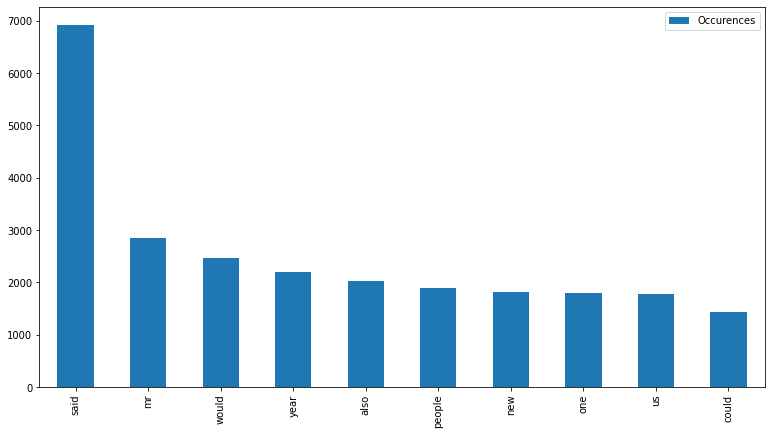

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features

27595

### 2.2 Data Stemming

In [ ]:
# def stemming(text, stemmer):
#   text = [stemmer.stem(word) for word in text.split()]
#   return ' '.join(text)

In [ ]:
# from nltk.stem import PorterStemmer
# sb_stemmer = PorterStemmer()

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatiser =  WordNetLemmatizer()

In [ ]:
def lemmar(text, lemmer):
  text = [lemmer.lemmatize(word, pos='v') for word in text.split()]
  return ' '.join(text)

In [ ]:
# sb_stemmer = SnowballStemmer('english')

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
data['Description'] = data['Description'].apply(lemmar, lemmer=lemmatiser)

In [ ]:
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

<AxesSubplot:>

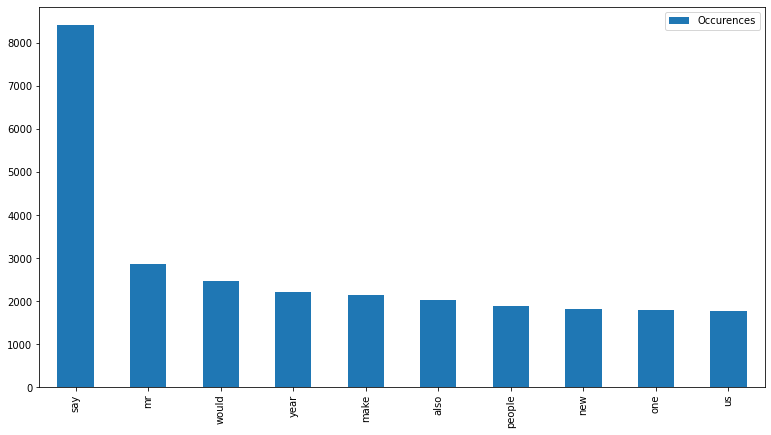

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features

22563

### 2.3 Removing further stopwords and Tokenising

In [ ]:
stop_words.extend(['said', 'mr', 'would', 'also', 'could'])
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
tokeniser = CountVectorizer(max_df = 0.95, min_df = 5)
# https://datascience.stackexchange.com/questions/21950/why-we-should-not-feed-lda-with-tfidf
tokenised_data = tokeniser.fit_transform(data['Description'])

In [ ]:
top_words, n_features = top_n_words_features(tokeniser, data['Description'], 10)

<AxesSubplot:>

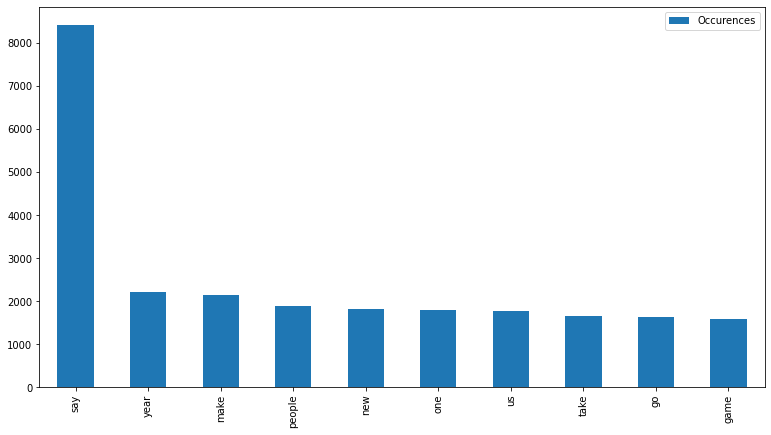

In [ ]:
top_words.plot(kind = 'bar', figsize = (13,7))

In [ ]:
n_features

7032

## 3. LDA

### 3.1 LDA Model Fitting with Hyperparameter tuning

In [ ]:
%%time
lda = LatentDirichletAllocation()
grid_params = {'n_components' : list(range(5,6))}
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(tokenised_data)

CPU times: user 1min 9s, sys: 218 ms, total: 1min 10s
Wall time: 1min 28s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [5]})

In [ ]:
best_lda_model = lda_model.best_estimator_
print("Parameters on Best LDA Model" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on data", best_lda_model.perplexity(tokenised_data))

Parameters on Best LDA Model {'n_components': 5}
Best log likelihood Score for the LDA model -714627.1893375812
LDA model Perplexity on data 1919.2755872554337


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, tokenised_data, tokeniser, mds='tsne')
lda_panel

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:300

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      133.521774  -39.061417       1        1  32.911802
3      -57.820530   28.855337       2        1  27.671217
1       57.251541   57.576988       3        1  15.888382
2       32.833054 -102.562439       4        1  13.238046
0      -85.785286  -90.959702       5        1  10.290552, topic_info=       Term         Freq        Total Category  logprob  loglift
2391   film  1038.000000  1038.000000  Default  30.0000  30.0000
2596   game  1533.000000  1533.000000  Default  29.0000  29.0000
584    best   904.000000   904.000000  Default  28.0000  28.0000
456   award   584.000000   584.000000  Default  27.0000  27.0000
4144  music   717.000000   717.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
7003   year   177.660122  2174.674488   Topic5  -5.4698  -0.2308
6366   time   167.223038  1553.947028   Topic5  -5.5303   0.0447
4372    one   159.439602  1762.549422   Topic5  -5.5780  -0.1289
6963  world   145.944212  1115.317462   Topic5  -5.6664   0.2403
3563   last   146.180868  1327.193835   Topic5  -5.6648   0.0680

[410 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
31        1  0.092725   access
31        2  0.897748   access
31        4  0.008430   access
69        4  0.993600    actor
69        5  0.005257    actor
...     ...       ...      ...
7005      4  0.214230    years
7005      5  0.105532    years
7021      1  0.979354  yugansk
7023      1  0.995633    yukos
7026      5  0.992490  zealand

[863 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

### 3.2 Assigning the different clusters to the Category names

In [ ]:
def assign_topics(data, tokenised, lda_model):
  topic_dist = lda_model.transform(tokenised)
  # https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda
  topics = []
  for doc in topic_dist:
    topics.append(doc.argmax() + 1)
    # https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
  topics_df = pd.DataFrame(topics).rename(columns = {0:'Topics_LDA'})
  return pd.merge(data, topics_df, left_index = True, right_index = True)
  # https://sparkbyexamples.com/pandas/pandas-merge-two-dataframes-by-index/#:~:text=Merge%20DataFrames%20by%20Index%20Using%20pandas.&text=You%20can%20use%20pandas.,and%20by%20default%2C%20the%20pd.

In [ ]:
result_df = assign_topics(data, tokenised_data, best_lda_model)

In [ ]:
result_df.groupby(['Category', 'Topics_LDA'], as_index=True)['Title'].count()

Category       Topics_LDA
Business       3               8
               4              15
               5             480
Entertainment  1              26
               2               1
               3             307
               4              27
               5               8
Politics       1               9
               2              15
               4             116
               5             263
Sport          1             152
               2             346
               3               2
               5               3
Tech           1               5
               2               2
               3               8
               4             329
               5               3
Name: Title, dtype: int64

In [ ]:
def convert_labels(result):
  to_map = result.groupby(['Category', 'Topics_LDA'], as_index=False)['Title'].count()
  to_map = to_map.groupby('Category', as_index=False).apply(lambda x: x['Topics_LDA'][x['Title'].idxmax()]).rename(columns = str).rename(columns = {'None':'LDA'})
  # https://stackoverflow.com/questions/45161355/pandas-dataframe-find-the-max-after-groupby-two-columns-and-get-counts
  # https://stackoverflow.com/questions/45545675/rename-pandas-dataframe-with-nan-header
  to_map_dict = dict(zip(to_map['LDA'], to_map['Category']))
  # https://stackoverflow.com/questions/18695605/how-to-convert-a-dataframe-to-a-dictionary
  result['Topic_LDA'] = result['Topics_LDA'].map(to_map_dict)
  # https://www.projectpro.io/recipes/map-values-in-pandas-dataframe
  result.drop('Topics_LDA', axis=1, inplace=True)
  return result

In [ ]:
result_df = convert_labels(result_df)

In [ ]:
result_df['Topic_LDA'].value_counts()

Politics         757
Tech             487
Sport            364
Entertainment    325
Name: Topic_LDA, dtype: int64

### 3.3 Computing the Model Accuracy and Individual Topic Precisions

<AxesSubplot:>

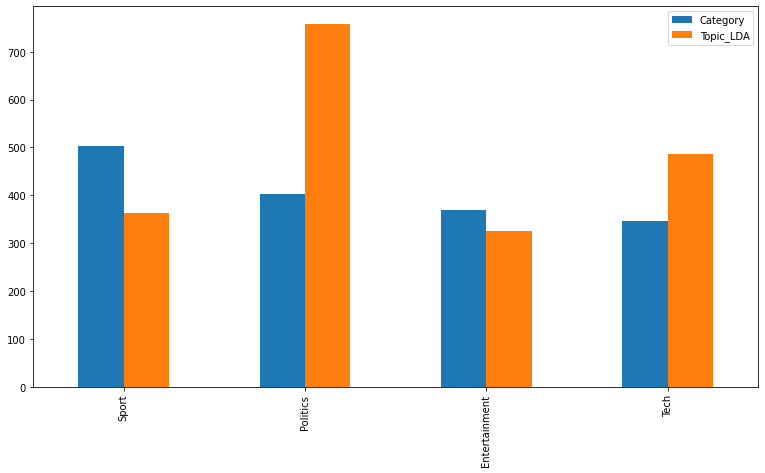

In [ ]:
aggregated_input = pd.DataFrame(result_df['Category'].value_counts())
aggregated_LDA = pd.DataFrame(result_df['Topic_LDA'].value_counts())
aggregated = pd.merge(aggregated_input, aggregated_LDA, left_index=True, right_index=True)

aggregated.plot(kind='bar', figsize=(13,7))

In [ ]:
def tag_precision(result):
  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})
  predicted_articles_total = df1.groupby('Topic_LDA')['Count'].sum().reset_index()
  predicted_articles = df1[df1['Category'] == df1['Topic_LDA']]['Count'].reset_index()['Count']
  predicted_articles_total['Count'] = (predicted_articles/predicted_articles_total['Count'])*100
  return predicted_articles_total.rename(columns = {'Count':'Precision'})

def model_accuracy(result):
  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})
  correct_preds = df1[df1['Category'] == df1['Topic_LDA']]['Count'].reset_index()['Count'].sum()
  total_accuracy = correct_preds/result.shape[0]
  return total_accuracy * 100

In [ ]:
tag_precision(result_df)

,Topic_LDA,Precision
0,Entertainment,94.461538
1,Politics,34.742404
2,Sport,95.054945
3,Tech,67.556468


In [ ]:
model_accuracy(result_df)

58.58823529411765

### 3.4 Topic-wise Analysis - Top words for each topic

In [ ]:
topic_terms = lda_panel.token_table.sort_values(by = ['Freq'], ascending=False)

In [ ]:
def top_n_terms(n, topic_terms):
  topic_terms_df = pd.DataFrame(topic_terms.groupby('Topic')['Term'].apply(list))
  term_frequency_df = pd.DataFrame(topic_terms.groupby('Topic')['Freq'].apply(list))
  # https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
  topic_terms_df = pd.DataFrame(topic_terms_df['Term'].str[:n])
  term_frequency_df = pd.DataFrame(term_frequency_df['Freq'].str[:n])
  term_freq_list = []
  for i in range(5):
    term_freq_list.append({topic_terms_df.iloc[i,0][j] : term_frequency_df.iloc[i,0][j] for j in range(n)})
  return term_freq_list

def plot_wordcloud(topic_term_freq):
  colours = ['black', 'steelblue', 'darkslateblue', 'darkolivegreen', 'khaki']
  wordcloud = WordCloud(width = 1300, height = 800,
                  background_color = random.choice(colours),
                  min_font_size = 10).generate(' '.join(list(topic_term_freq.keys())))
  # https://www.geeksforgeeks.org/randomly-select-n-elements-from-list-in-python/
  # https://matplotlib.org/stable/gallery/color/named_colors.html
  wordcloud = wordcloud.generate_from_frequencies(frequencies = topic_term_freq)
  plt.figure(figsize = (13,8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  plt.show()

In [ ]:
term_freqs = top_n_terms(100, topic_terms)

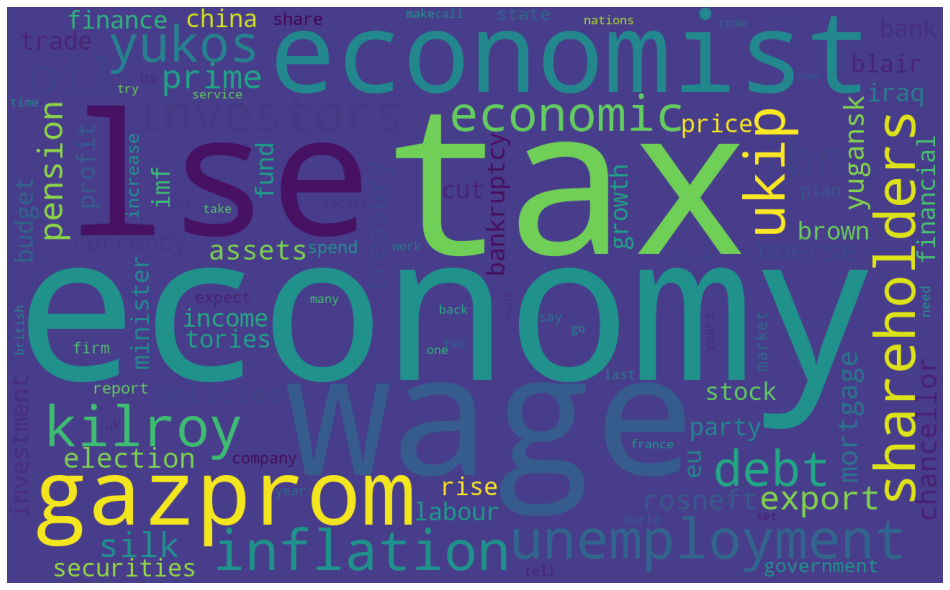

In [ ]:
plot_wordcloud(term_freqs[0])

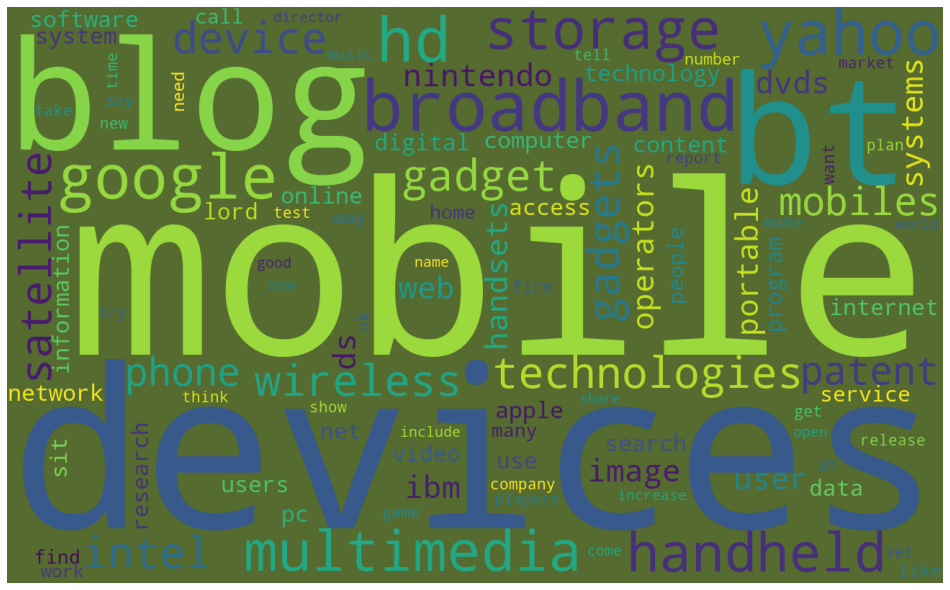

In [ ]:
plot_wordcloud(term_freqs[1])

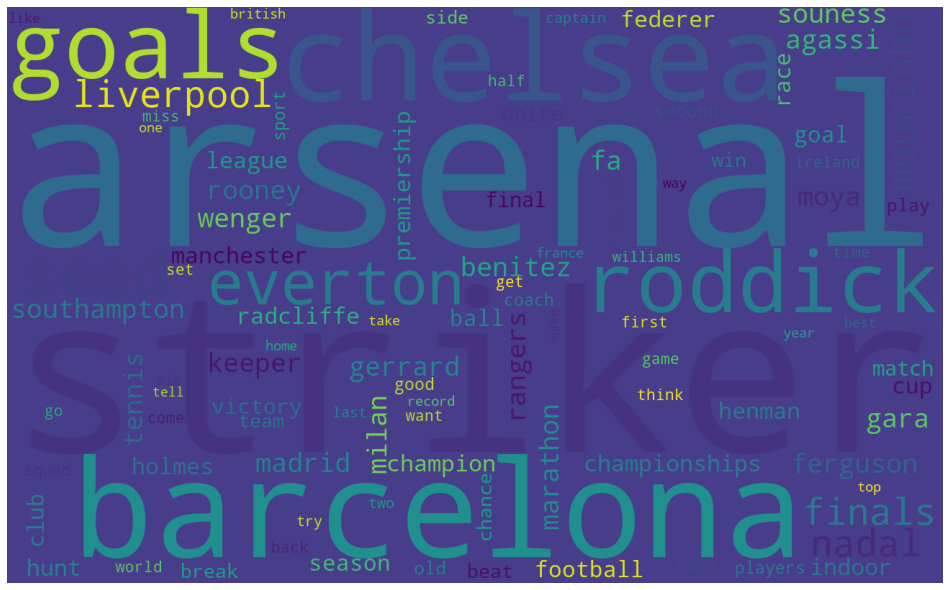

In [ ]:
plot_wordcloud(term_freqs[2])

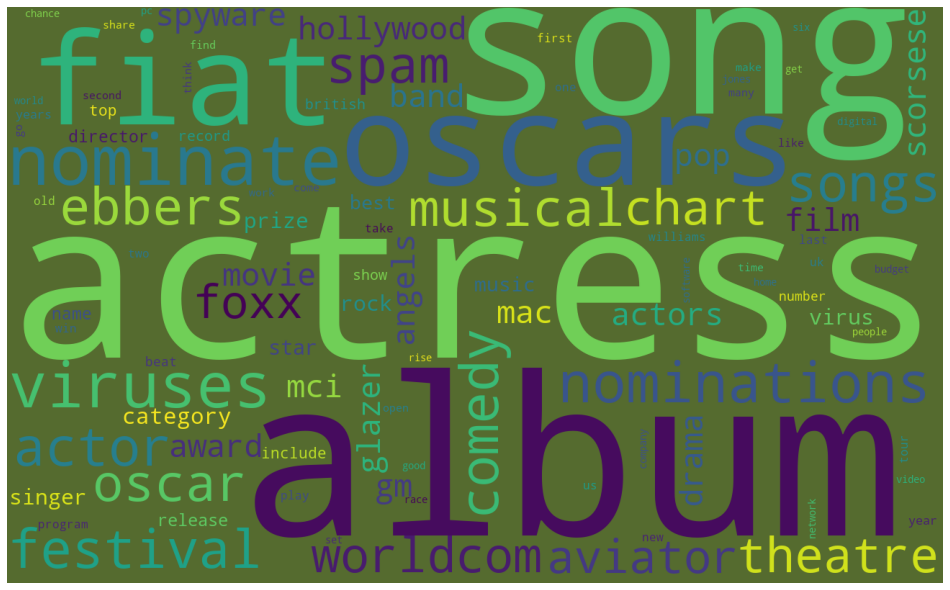

In [ ]:
plot_wordcloud(term_freqs[3])

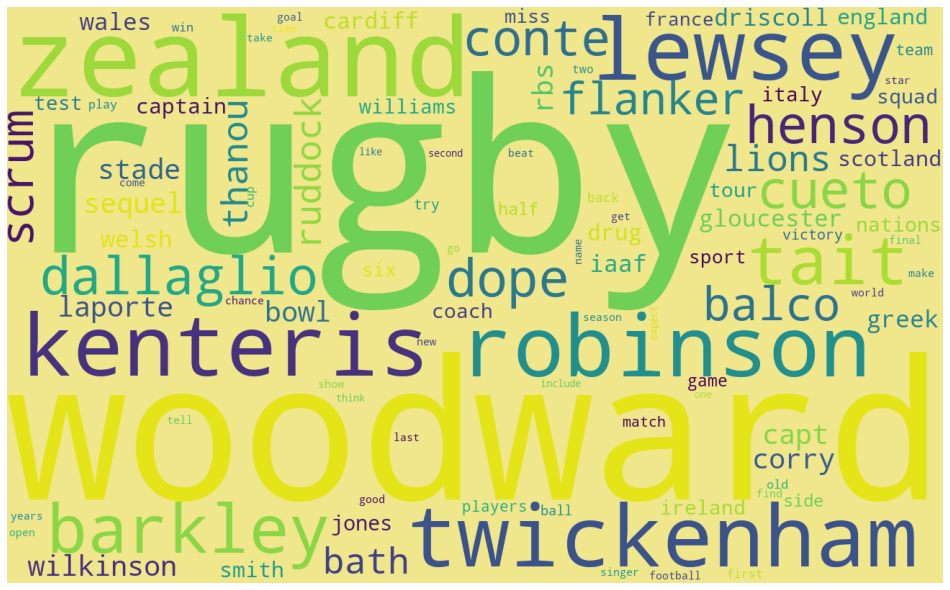

In [ ]:
plot_wordcloud(term_freqs[4])

https://github.com/pratheekTM/Topic-Modeling-on-BBC-News-Articles
https://github.com/Keshav1506/Topic-Modelling-on-BBC-News-Articles-using-LDA/blob/main/Topic_Modelling_on_BBC_News_Articles.ipynb
https://github.com/Kaustubh-Tambe/BBC-News_Topic-Modelling/blob/main/Notebook/BBC_News_Topic_Modelling_Project.ipynb

In [ ]:
result_df.to_csv(path + "Result_1_1.csv")